### Criando um sistema de reconhecimento facial do zero

<p align="left">
  <img src="https://img.shields.io/static/v1?label=&message=Python&color=blue&style=for-the-badge&logo=python"/>
  <img src="https://img.shields.io/static/v1?label=&message=openCV&color=blue&style=for-the-badge&logo=openCV"/>
  <img src="https://img.shields.io/static/v1?label=&message=PyTorch&color=blue&style=for-the-badge&logo=pytorch"/>
  <img src="http://img.shields.io/static/v1?label=STATUS&message=CONCLUIDO&color=GREEN&style=for-the-badge"/>
</p>


Este Projeto foi realizado por Maurício André de Almeida como trabalho no curso de Frameworks de Deep Learning na DIO.ME

Projeto de reconhecimento facial em Python com OpenCV e pyTorch

O objetivo principal deste projeto é trabalhar com as bibliotecas e frameworks estudados e analisados em nossas aulas. Neste sentido, a proposta padrão envolve um sistema de detecção e reconhecimento de faces, utilizando o framework TensorFlow em conjuntos com as bibliotecas que o projetista julgue necessárias, de forma ilimitada. 

O projeto consiste em aplicar o método de Transfer Learning em uma rede de Deep Learning para reconhecimento facial e depois utilizá-la para reconhecer e identificar faces em uma imagem com várias pessoas.

Foram executados os seguintes passos:
- Download local do dataset com 307 celebridades (tageados e separados em train e test) 
- Carregar um modelo pré-treinado RESNET50.
- Alterar a saída para 307 categorias.
- Treinar novamente o modelo com o dataset de celebridades.
- Testar o treinamento.
- Baixar da internet algumas imagens com grupos de celebridades na mesma imagem.
- Carregar os grupos no diretório Dataset\groups.
- Utilizar o OpenCV com o haarcascade_frontalface para detectar as faces
- Gravar cada face encontrada em um array.
- Submeter ao modelo treinado para identificar a celebridade.
- Marcar a imagem do grupo com um retangulo e o label da celebridade para cada face.
- Exibir o resultado.


# <b>Dataset de Celebridades</b>

Foi utilizado o seguinte dataset baseado no CelebAMask-HQ dataset, porém com apenas 307 identidades e 5578 imagens. 
* <b>dataset Celeb-HQ</b>: [Celeb-HQ](https://github.com/ndb796/LatentHSJA

* <b>Original dataset</b>: [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<b>ESTRUTURA DO DATASET</b>
<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>


https://github.com/ndb796/LatentHSJA
@inproceedings{na2022unrestricted,
  title={Unrestricted Black-Box Adversarial Attack Using GAN with Limited Queries},
  author={Na, Dongbin and Ji, Sangwoo and Kim, Jong},
  booktitle={European Conference on Computer Vision},
  pages={467--482},
  year={2022},
  organization={Springer}
}





### <b>Carreagando o Dataset</b>

* Definir o diretório das imagens e inicializar o PyTorch e demais bibliotecas utilizadas.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2 
from PIL import Image
import time
import os
import glob

device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


# Preparando os datasets para treinamento e testes

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

data_dir = './Dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

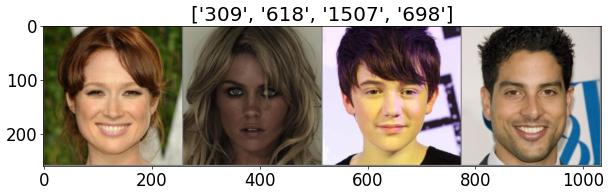

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(inputs, title):
    # torch.Tensor => numpy
    inputs = inputs.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    # display images
    plt.imshow(inputs)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Carregando o modelo pré-treinado: RESNET50</b>

* utilizando transfer learning do modelo treinado com o o IMAGENET

In [4]:
#model = models.resnet18(weights='IMAGENET1K_V1')
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 307) # Alterando a classificação para as 307 identidades do dataset escolhido
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\mauri/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100.0%


### <b>Realizando o treinamento</b>

* Utilizei apenas 10 épocas para reduzir o tempo de treinamento

In [5]:
num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    
    model.train()

    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

  
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 5.5948 Acc: 2.0643% Time: 90.1094s
[Test #0] Loss: 4.9806 Acc: 7.0782% Time: 113.7845s
[Train #1] Loss: 3.9183 Acc: 20.9008% Time: 200.2027s
[Test #1] Loss: 3.2943 Acc: 28.3951% Time: 219.7556s
[Train #2] Loss: 1.9169 Acc: 56.2280% Time: 313.9785s
[Test #2] Loss: 2.1918 Acc: 47.9835% Time: 335.3092s
[Train #3] Loss: 0.8155 Acc: 81.2808% Time: 415.3009s
[Test #3] Loss: 1.5551 Acc: 63.7037% Time: 436.5069s
[Train #4] Loss: 0.3354 Acc: 93.1269% Time: 507.3671s
[Test #4] Loss: 1.3108 Acc: 67.5720% Time: 517.5340s
[Train #5] Loss: 0.1347 Acc: 97.9826% Time: 583.3791s
[Test #5] Loss: 1.0881 Acc: 73.6626% Time: 593.3154s
[Train #6] Loss: 0.0652 Acc: 99.3432% Time: 659.1038s
[Test #6] Loss: 0.8665 Acc: 79.5062% Time: 668.8953s
[Train #7] Loss: 0.0254 Acc: 99.9062% Time: 735.0245s
[Test #7] Loss: 0.8329 Acc: 80.3292% Time: 745.1779s
[Train #8] Loss: 0.0251 Acc: 99.7889% Time: 812.2934s
[Test #8] Loss: 0.8692 Acc: 79.8354% Time: 822.1251s
[Train #9] Loss: 0.0295 Acc: 99.5778% Ti

### <b>Gravando o modelo treinado para uso futuro</b>



In [6]:
save_path = 'identificacao_facial_ResNet18_resolution_256_normalize_05.pth'
torch.save(model.state_dict(), save_path)

# Utilizando haarcascade para detectar as faces nas imagens com grupos de celebridades

* Abrir cada imagem no diretório: Dataset\group
* Detectar as faces na imagem
* Submeter cada face encontrada ao modelo para identificar a celebridade
* Marcar na imagem do grupo cada face e o numero correspondente à categoria (Celebridade) encontrada

OBS: Infelizmente no dataset original não havia a informação do nome de cada celebridade, então foi utilizado apenas o ID

In [7]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def listar_arquivos_jpg(diretorio):
    diretorio = os.path.join(diretorio, "") 
    arquivos_jpg = glob.glob(os.path.join(diretorio, "*.jpg"))
    return arquivos_jpg



# Realizando a detecção das faces com openCV e identificando-os com o modelo RESNET50 treinado

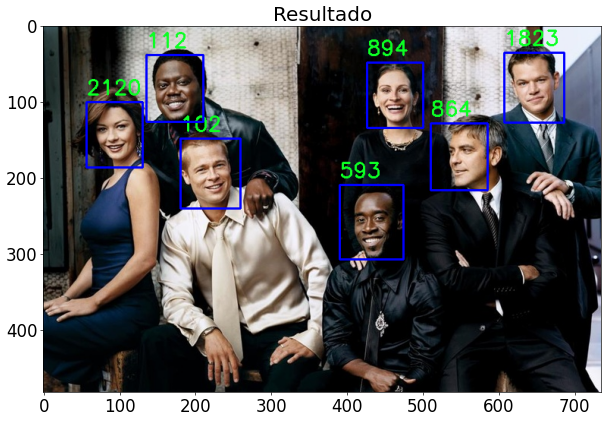

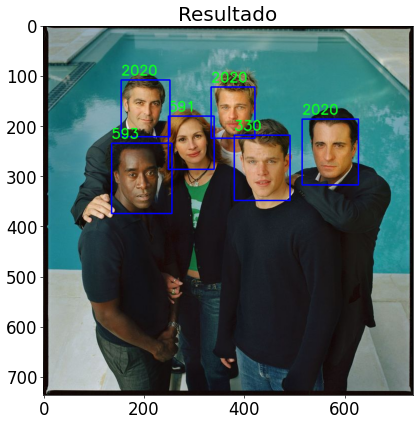

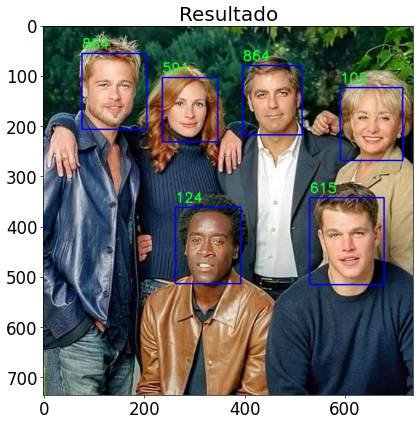

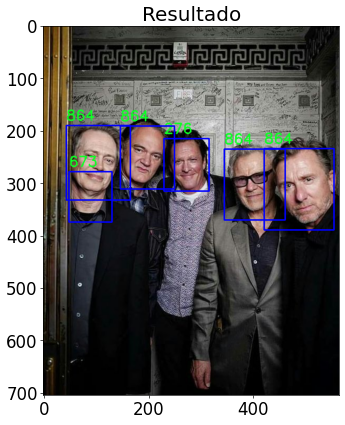

In [16]:

grupos_jpg = listar_arquivos_jpg('Dataset/group')
imgfaces = []
imglabels = []
model.to(device)
for file in grupos_jpg:
    imgfaces = []
    img = cv2.imread(file)
    orig = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 3)

    for (x, y, w, h) in faces:
        h_offset = int(h * 0.4)  # Adicionar 40% na altura
        w_offset = int(w * 0.2)  # Adicionar 20% na largura
        x = max(0, x - w_offset // 2)  # Mover a esquerda
        w = w + w_offset               # aumentar a largura
        y = max(0, y - h_offset // 2)  # Mover o topo para cima
        h = h + h_offset               # aumentar a altura
        # Recortar a face na imagem original
        face_img = cv2.cvtColor(orig[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
        
        # redimensionar a imagem para 256x256 e converter para tensor
        resized_img = cv2.resize(face_img, (256, 256))
        pil_img = Image.fromarray(resized_img)

        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
        input_tensor = transform(pil_img).unsqueeze(0).to(device)
        # Realizar a predição
        with torch.no_grad(): 
           output = model(input_tensor)
        _, pred = torch.max(output, 1)
        #print(pred)
        label = class_names[pred]
        #plt.subplot(1, 2, 1)
        #plt.imshow(pil_img)
        #plt.title("Face detectada")
        
        #celeb_folder = listar_arquivos_jpg('Dataset/train/' + label)
        #for celeb in celeb_folder:
        #    celeb_img = cv2.cvtColor( cv2.imread(celeb), cv2.COLOR_BGR2RGB)
        #    plt.subplot(1, 2, 2)
        #    plt.imshow(celeb_img)
        #    plt.title("Face encontrada")
        #    break
        #plt.show()
        
        imgfaces.append(celeb_img)
        imglabels.append(label)
        
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    img_c = cv2.cvtColor( img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_c)
    plt.title("Resultado")
    plt.show()
